In [2]:
import data_loader as dl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
np.random.seed(0)

train_df, valid_df = dl.load_train_data("adult.data")
test_df = dl.load_test_data("adult.test")
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'martial.status',
                   'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss',
                   'hours.per.week', 'native.country', 'income']
train_df.columns = column_names
train_df.replace(' ?', np.nan, inplace=True)
from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mode.fit(train_df)
imp_train_df = imp_mode.transform(train_df)
train_df = pd.DataFrame(imp_train_df, columns = column_names)

for col in ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
    train_df[col] = train_df[col].astype('int64')
for col in ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 
            'sex', 'native.country', 'income']:
    train_df[col] = train_df[col].astype('category')
train_df['capital.gain.loss'] = train_df['capital.gain'] - train_df['capital.loss']
num_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'capital.gain.loss']
cat_features = ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
cat_features.remove("education")
cat_features.remove("relationship")
cat_features.remove("income")

for cat in cat_features:
    train_df = pd.concat([train_df,pd.get_dummies(train_df[cat], prefix='is')],axis=1)
    train_df.drop([cat],axis=1, inplace=True)
train_df['income.prediction'] = train_df.income.cat.codes
train_df.drop(labels=["fnlwgt", "education","relationship", "income"], axis = 1, inplace = True)

valid_df.columns = column_names
valid_df.replace(' ?', np.nan, inplace=True)
imp_train_df = imp_mode.transform(valid_df)
valid_df = pd.DataFrame(imp_train_df, columns = column_names)

for col in ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
    valid_df[col] = valid_df[col].astype('int64')
for col in ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 
            'sex', 'native.country', 'income']:
    valid_df[col] = valid_df[col].astype('category')
valid_df['capital.gain.loss'] = valid_df['capital.gain'] - valid_df['capital.loss']
num_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'capital.gain.loss']
cat_features = ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
cat_features.remove("education")
cat_features.remove("relationship")
cat_features.remove("income")

for cat in cat_features:
    valid_df = pd.concat([valid_df,pd.get_dummies(valid_df[cat], prefix='is')],axis=1)
    valid_df.drop([cat],axis=1, inplace=True)
valid_df['income.prediction'] = valid_df.income.cat.codes
valid_df.drop(labels=["fnlwgt", "education","relationship", "income"], axis = 1, inplace = True)
missing_cols = set( train_df.columns ) - set( valid_df.columns )
for c in missing_cols:
    valid_df[c] = 0
valid_df = valid_df[train_df.columns]

test_df.columns = column_names
test_df.replace(' ?', np.nan, inplace=True)
imp_train_df = imp_mode.transform(test_df)
test_df = pd.DataFrame(imp_train_df, columns = column_names)

for col in ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']:
    test_df[col] = test_df[col].astype('int64')
for col in ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 
            'sex', 'native.country', 'income']:
    test_df[col] = test_df[col].astype('category')
test_df['capital.gain.loss'] = test_df['capital.gain'] - test_df['capital.loss']
num_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'capital.gain.loss']
cat_features = ['workclass', 'education', 'martial.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
cat_features.remove("education")
cat_features.remove("relationship")
cat_features.remove("income")

for cat in cat_features:
    test_df = pd.concat([test_df,pd.get_dummies(test_df[cat], prefix='is')],axis=1)
    test_df.drop([cat],axis=1, inplace=True)
test_df['income.prediction'] = test_df.income.cat.codes
test_df.drop(labels=["fnlwgt", "education","relationship", "income"], axis = 1, inplace = True)
missing_cols = set( train_df.columns ) - set( test_df.columns )
for c in missing_cols:
    test_df[c] = 0
test_df = test_df[train_df.columns]


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from collections import namedtuple

Model = namedtuple('Model', 'name model')

train = train_df.values
X, Y= train[:,:-1], train[:,-1]
valid = valid_df.values
Xval, Yval = valid[:,:-1], valid[:,-1]
test = test_df.values
Xtst, Ytst = test[:,:-1], test[:,-1]

models = []
models.append(Model('LR', LogisticRegression(solver='liblinear')))
models.append(Model('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(Model('DT', DecisionTreeClassifier(max_depth=25)))
models.append(Model('RF', RandomForestClassifier(n_estimators=50)))
models.append(Model('GB', GradientBoostingClassifier(n_estimators=1000)))

for m in models:
    m.model.fit(X, Y)
    print(m.name)
    Yhat = m.model.predict(X)
    auc = roc_auc_score(Y, Yhat)
    acc = accuracy_score(Y, Yhat)
    print("Training AUC: {}".format(auc))
    print("Training ACC: {}".format(acc))
    Yhat = m.model.predict(Xval)
    auc = roc_auc_score(Yval, Yhat)
    acc = accuracy_score(Yval, Yhat)
    print("Validation AUC: {}".format(auc))
    print("Validation ACC: {}".format(acc))
    Yhat = m.model.predict(Xtst)
    auc = roc_auc_score(Ytst, Yhat)
    acc = accuracy_score(Ytst, Yhat)
    print("Test AUC: {}".format(auc))
    print("Test ACC: {}".format(acc))

LR
Training AUC: 0.7641522542652434
Training ACC: 0.851031894934334
Validation AUC: 0.7562438021911996
Validation ACC: 0.8468884781269255
Test AUC: 0.7575874735833824
Test ACC: 0.8501320557705301
KNN
Training AUC: 0.839093005507156
Training ACC: 0.8914207743476036
Validation AUC: 0.7629646861150472
Validation ACC: 0.8394947627849662
Test AUC: 0.7737198173089771
Test ACC: 0.8458325655672256
DT
Training AUC: 0.9232337079612396
Training ACC: 0.9494797885041788
Validation AUC: 0.7711903249047564
Validation ACC: 0.8308687615526802
Test AUC: 0.7510543437419042
Test ACC: 0.8239665868189915
RF
Training AUC: 0.9627315118931064
Training ACC: 0.9753368582636875
Validation AUC: 0.7693072544604285
Validation ACC: 0.8478126925446704
Test AUC: 0.7645351773057654
Test ACC: 0.8467538848965052
GB
Training AUC: 0.8249969269533672
Training ACC: 0.8900903974074705
Validation AUC: 0.7886749915590164
Validation ACC: 0.866913123844732
Test AUC: 0.7975983695560127
Test ACC: 0.8729807751366624


In [15]:
model = GradientBoostingClassifier(n_estimators=1000)
model.fit(X, Y)
Yhat = model.predict(X)
auc = roc_auc_score(Y, Yhat)
acc = accuracy_score(Y, Yhat)
print("Training AUC: {}".format(auc))
print("Training ACC: {}".format(acc))
Yhat = model.predict(Xval)
auc = roc_auc_score(Yval, Yhat)
acc = accuracy_score(Yval, Yhat)
print("Validation AUC: {}".format(auc))
print("Validation ACC: {}".format(acc))
Yhat = model.predict(Xtst)
auc = roc_auc_score(Ytst, Yhat)
acc = accuracy_score(Ytst, Yhat)
print("Test AUC: {}".format(auc))
print("Test ACC: {}".format(acc))

Training AUC: 0.8249969269533672
Training ACC: 0.8900903974074705
Validation AUC: 0.7886749915590164
Validation ACC: 0.866913123844732
Test AUC: 0.7977283747562207
Test ACC: 0.873042196425281


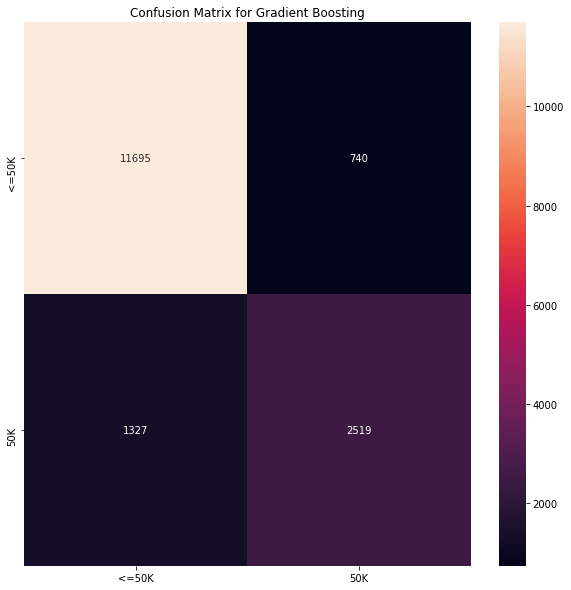

In [16]:
cm = confusion_matrix(Ytst, Yhat)
df_cm = pd.DataFrame(cm, index = [i for i in ["<=50K", "50K"]],
                  columns = [i for i in ["<=50K", "50K"]])
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion Matrix for Gradient Boosting")
plt.show()